In this assignment, you need to analyze a large set of customer reviews and come up with recommendations to the Singapore Airlines CEO to improve customer satisfaction.

The notebook serves as a starting point for your analysis.

At the end of the assignment, you should deliver a five-slide "elevator pitch" to the CEO summarizing your findings and recommendations, backing up your claims with analyses.

# Topic Modeling with Transformers

We have seen that transformers are a powerful tool to build encodings of text that capture context, order of words, etc... Typically, one uses a pre-trained transformer to produce the encodings, and then feeds these to their own model (e.g. a neural network) to solve their particular NLP task, like sentiment analysis or sequence labeling.

In this notebook, you will solve another NLP task called topic analysis (more on that later). You will use the BERTopic package for this task, which is built on top of HuggingFace transformers.

With BERTopic, you will analyze a dataset of Singapore Airlines customer reviews to gain insight into how to improve the customer experience.

You can find an expansive description of the dataset here
https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

We load the data and output some summary of the data columns.

In [7]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [9]:
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [10]:
## If you want to see more text from the review, you can increase the display.max_colwidth

#pd.set_option('display.max_colwidth', 50)

## Quick summary statistics and visualizations

Let's look at some summary statistics for our dataset. For example, are there any interesting trends, or relationships between the length of reviews, presence of specific words, and ratings.

In [11]:
# Step 1: Calculate the length of each review
df['review_length'] = df['text'].apply(len)

# For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

# Preparing data for visualization
# We'll aggregate data to see if there's a visible trend between the length of reviews, presence of specific words, and ratings
aggregated_data = df.groupby('rating').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean'
}).reset_index()

aggregated_data

,rating,review_length,contains_excellent,contains_terrible
0,1,920.468307,0.021760,0.096500
1,2,871.423573,0.053407,0.071823
2,3,737.867195,0.080278,0.042616
3,4,526.661922,0.149466,0.006101
4,5,431.168326,0.222345,0.002028


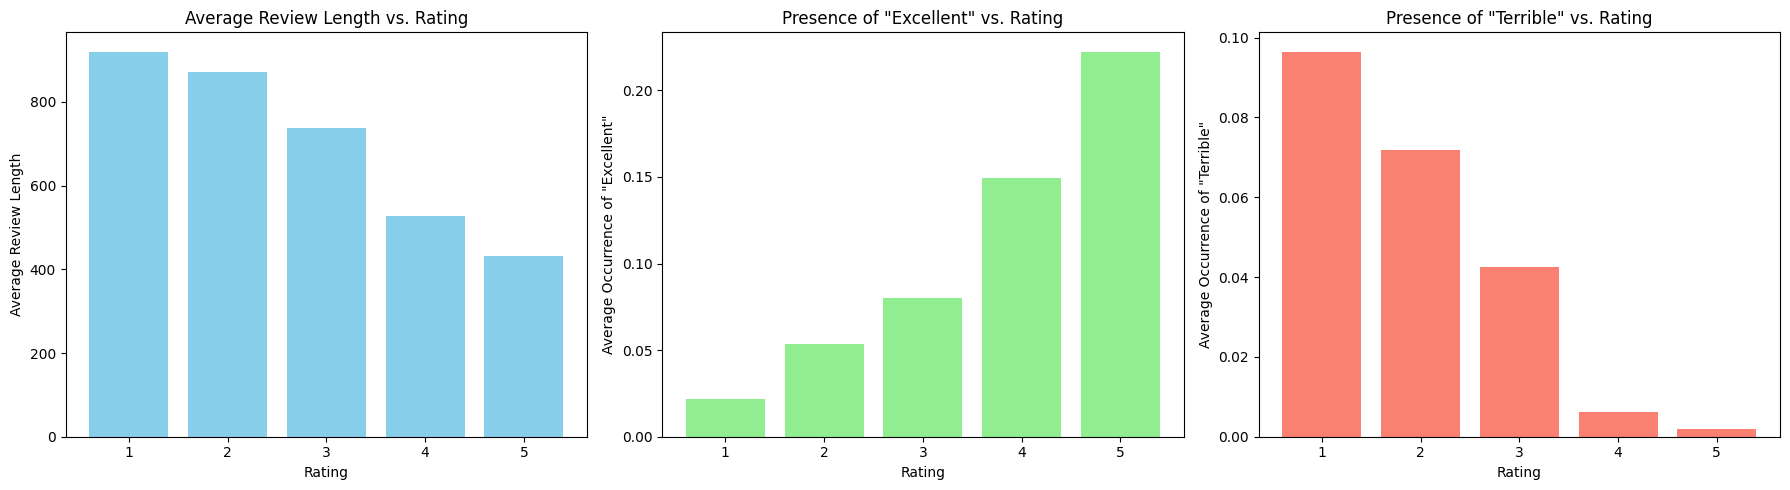

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Review length vs. rating
axes[0].bar(aggregated_data['rating'], aggregated_data['review_length'], color='skyblue')
axes[0].set_title('Average Review Length vs. Rating')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. rating
axes[1].bar(aggregated_data['rating'], aggregated_data['contains_excellent'], color='lightgreen')
axes[1].set_title('Presence of "Excellent" vs. Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. rating
axes[2].bar(aggregated_data['rating'], aggregated_data['contains_terrible'], color='salmon')
axes[2].set_title('Presence of "Terrible" vs. Rating')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Average Occurrence of "Terrible"')

plt.tight_layout()
plt.show()

We next aggregate the data by year, and plot how the ratings have changed over time.


In [13]:
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,review_length,contains_excellent,contains_terrible,year
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,1352,0,0,2024
1,2024-03-11 23:39:13+00:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,4666,1,0,2024
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,420,0,0,2024
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,144,0,0,2024
4,2024-03-10 09:34:18+00:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,582,0,0,2024


In [14]:
aggregated_data = df.groupby('year').agg({
    'rating': 'mean',
}).reset_index()

aggregated_data

,year,rating
0,2018,4.319710
1,2019,4.246012
2,2020,4.046103
3,2021,2.435294
4,2022,2.181159
5,2023,2.684112
6,2024,2.333333


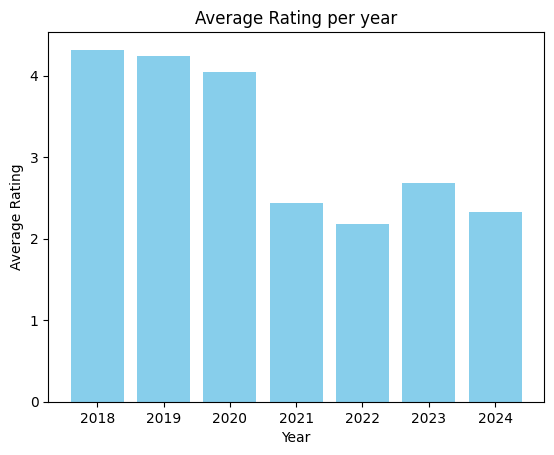

In [15]:
plt.bar(aggregated_data['year'], aggregated_data['rating'], color='skyblue')
plt.title('Average Rating per year')
plt.xlabel('Year')
plt.ylabel('Average Rating')

plt.show()

# Ooops...

There seems to be a meaningful drop in ratings from 2021 onwards. Imagine you report to the Singapore Airlines CEO and you need to formulate a plan of action to improve this situation. It would be nice to see what has gone wrong.

Fortunately, you have the review data that may contain some information about what could be going wrong. This is where topic modeling comes in to help. In short, [topic modeling is a technique that allows you to extract "topics" that occur in a large collection of text](https://en.wikipedia.org/wiki/Topic_model). In this notebook, you will use BERTopic, a topic modeling package built on top of HuggingFace transformers.

Your task is to use BERTopic to explain the negative shift in ratings, and then present your findings as a one-slide pitch that you will present in class.

First, load up BERTopic and familiarize yourselves with its functionality.

# Topic analysis using BERTopic

In this assignment, you will not need to build a transformer per se. What you will do is use an ML package that uses a pre-trained transformer to solve a specific NLP task. In this case, that is topic modeling.

First, if running on Colab (which is highly recommended at least for creating your topic model), you will need to install the package:

In [16]:
from bertopic import BERTopic

In [17]:
topic_model = BERTopic(embedding_model = 'all-MiniLM-L6-v2')

It can take a long time to train the topic model on the entire dataset. To reduce the load, we slice the dataset by year 2019 and run training.

Also, note that so far we are not making any specifications about the training process. The [documentation for BERTopic](https://maartengr.github.io/BERTopic/index.html) gives lots of information on how to tweak the fitting behavior (and how to access different [embeddings](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html), etc.). It also pays to take a look at the [best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html).

In [18]:
df_slice = df[(df['year'] == 2019)]

In [19]:
topics, probs = topic_model.fit_transform(df_slice['text'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Ok, let's see what this topic_model has to say. The following command returns the list of topics ordered by frequency. You can also see the most relevant words for the topic, and the most relevant reviews.

Note: topic -1 is a dummy topic and should generally be ignored. It aggregates all the outliers and reviews that couldn't be clustered into a topic.

In [20]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2666,-1_the_and_to_was,"[the, and, to, was, of, flight, in, singapore,...",[My family and I recently flew on Singapore Ai...
1,0,175,0_singapore_to_from_in,"[singapore, to, from, in, flight, and, we, wer...",[Following a cruise holiday on the Sapphire Pr...
2,1,166,1_sq_is_to_the,"[sq, is, to, the, and, of, in, my, it, always]",[Iam writing this letter with my utmost sheer ...
3,2,151,2_airline_best_this_is,"[airline, best, this, is, service, the, and, a...",[This is the best airline in the world to fly ...
4,3,118,3_to_we_the_my,"[to, we, the, my, was, had, and, me, for, they]","[I am United 1K, Emirates Gold, and Star Allia..."
5,4,112,4_economy_premium_the_we,"[economy, premium, the, we, singapore, and, to...",[We have flown Singapore Airlines many times a...
6,5,101,5_seats_seat_was_comfortable,"[seats, seat, was, comfortable, and, very, the...",[Checking in online and bag drop very efficien...
7,6,93,6_economy_premium_seats_extra,"[economy, premium, seats, extra, the, more, wo...","[For the first time we flew Premium Economy, t..."
8,7,88,7_airlines_singapore_best_airline,"[airlines, singapore, best, airline, is, alway...","[Once again I had safe, clean, comfortable and..."
9,8,86,8_staff_crew_and_was,"[staff, crew, and, was, friendly, service, att...",[I was very impressed with the service and the...


You can also obtain information on a specific topic. For example below you can look into topic 2 and get the top words for that topic. The numbers on the right quantify the importance of those words to the topic.

In [21]:
topic_model.get_topic(2)

[('airline', 0.03655468505364194),
 ('best', 0.03177236238798948),
 ('this', 0.019687765423487227),
 ('is', 0.01864610933185067),
 ('service', 0.017625619550820194),
 ('the', 0.01716557117114518),
 ('and', 0.01651806716605475),
 ('are', 0.014734405340208595),
 ('food', 0.014330574972044423),
 ('great', 0.013843399839675597)]

Here, you can get representative reviews for a topic.

In [22]:
topic_model.get_representative_docs(2)

['This is the best airline in the world to fly with. Nothing is too much trouble for both the on ground team and in flight crew. The inflight service is first class, food is always of good quality. Flight schedules are excellent.',
 'We have travelled before with this airline and yet again an excellent flight. From the booking to flight service the staff are very good, food for an airline is also good. Would travel with them again and recommend you to try them.',
 'What can be said about the world’s best airline!  The planes are clean, staff are very friendly and helpful, the food is good (for plane food), and the entertainment is good.  I have travelled on other airlines, but this airline always get# a 10/10']

You can also visualize topic relationships in 2d space.

In [23]:
topic_model.visualize_topics()

Or visualize topic word scores.

In [24]:
topic_model.visualize_barchart()

Finally, it is often handy to visualize the term rank, to see clearly which topics have a particular focus on just a few words.

In [25]:
topic_model.visualize_term_rank()


Let's organize the topics and reviews in a dataframe.

In [26]:
topic_df = pd.DataFrame({"topic": topics, "document": df_slice['text']})
topic_df


,topic,document
2179,-1,I traveled with my family to Singapore for C...
2180,2,"The plane ride was excellent, new plane what a..."
2181,-1,Lots of good food and amenities. Their menu ev...
2182,16,Our night flight back from Narita was about 7 ...
2183,-1,Singapore Airport and airlines rank amongst th...
...,...,...
7377,-1,This flight was the day after we arrived in Si...
7378,-1,This was the first time we have flown with Sin...
7379,3,The meal was really good but for all other ele...
7380,40,The flight from Delhi to Bali via Singaore on...


# Your Task

Use BERTopic (as well as additional tools you deem useful) to arrive at a set of explanations for the drop in ratings, and a corresponding set of recommendations to the CEO.

You can consult any resources to find out about more of the functionality of BERTopic.

As an example of something you could do, try to slice the data, say by year. What happens when rerun the topic model on the data slice? Is there any menaingful information that comes out?

In general, this is an open-ended exercise. Be creative!

# Deliverables

See the assignment descriptions for a full overview of the deliverables.

# Your analysis

## 🔍 Why BERTopic?
BERTopic is a topic modeling technique that leverages transformer-based embeddings (e.g., BERT) to group similar documents and extract meaningful themes. It is particularly well-suited for our analysis of Singapore Airlines customer reviews due to several key advantages:
- Captures **context and word order**, crucial for nuanced customer language.
- Provides **interpretable topics** with keyword representations.
- Supports **dynamic topic modeling**, allowing before-and-after comparison (e.g., pre/post 2021).

We chose BERTopic for this project to reflect customer sentiment at a granular level, allowing us to go beyond ratings and uncover key drivers of dissatisfaction.


In [28]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from umap import UMAP
import pandas as pd
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from sklearn.decomposition import PCA


In this section, we fine-tune `BERTopic` using a combination of `UMAP` and `HDBSCAN` parameters to improve topic clarity and reduce noise.

We use `UMAP` for dimensionality reduction, as it preserves semantic structure better than PCA, especially in high-dimensional embedding spaces. This helps maintain the relationships between similar reviews when clustering.

For clustering, we tune HDBSCAN with varying `min_cluster_size` values to see how it affects topic granularity. HDBSCAN also identifies outliers (topic = -1), which we use to assess clustering quality.

Topic keywords are extracted using `CountVectorizer` and `class-based TF-IDF (c-TF-IDF)`. We explicitly pass a `ClassTfidfTransformer()` to support flexible tuning of how keywords represent each topic.

The model is applied to reviews from `2021` onwards, capturing recent customer concerns. For each parameter setting, we log the number of topics found and outliers detected—helping us identify the most effective model for extracting insights from customer feedback.

Using a `min_dist` value of 0.0, the UMAP model is encouraged to form tightly packed clusters, enabling it to capture fine-grained distinctions between data points.

In [29]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Filter the dataset to include only reviews from 2021 onwards — focusing the analysis on recent feedback.
df_slice2 = df[df['year'] >= 2021]

# Extract the review texts and convert them into a list of documents.
docs = df_slice2['text'].values.tolist()

# Convert review texts into numerical sentence embeddings using the loaded transformer model.
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Prepare to store the results of different parameter combinations.
results = []

# Loop over a set of hyperparameter combinations for clustering and dimensionality reduction.
for min_size in [20, 25, 30]:           
    for n_components in [3, 5]:  
        for n_neighbors in [10, 15]:  
            
            # Define a custom HDBSCAN clustering model with tuning parameters.
            hdbscan_model = HDBSCAN(
                min_cluster_size=min_size,
                metric='euclidean',
                cluster_selection_method='eom',
                prediction_data=True
            )

            # Define UMAP dimensionality reduction model with given parameters.
            umap_model = UMAP(
                n_neighbors=n_neighbors,
                n_components=n_components,
                min_dist=0.0,
                metric='cosine',
                random_state=42
            )

            # Initialize the BERTopic model with the specified components.
            model = BERTopic(
                embedding_model=embedding_model,          
                hdbscan_model=hdbscan_model,                
                umap_model=umap_model,                        
                ctfidf_model=ClassTfidfTransformer(),         
                verbose=False
            )

            # Fit the model on the documents and embeddings
            topics, _ = model.fit_transform(docs, embeddings)

            # Count the number of outlier documents (assigned to topic -1)
            outlier_count = sum([1 for t in topics if t == -1])

            # Store the results for this configuration
            results.append({
                "min_cluster_size": min_size,
                "n_components": n_components,
                "n_neighbors": n_neighbors,
                "num_topics": len(set(topics)) - (1 if -1 in topics else 0),  # Exclude outlier topic
                "outliers": outlier_count
            })

# Create a DataFrame with all tuning results and sort by fewest outliers (i.e., best clustering fit)
results_df = pd.DataFrame(results).sort_values(by="outliers", ascending=True)
results_df


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

,min_cluster_size,n_components,n_neighbors,num_topics,outliers
0,20,3,10,2,11
8,30,3,10,2,13
10,30,5,10,2,17
6,25,5,10,3,30
4,25,3,10,2,34
1,20,3,15,4,119
3,20,5,15,4,136
5,25,3,15,5,185
11,30,5,15,4,213
9,30,3,15,5,224


In [30]:
topic_info = topic_model.get_topic_info()
print(topic_info)

    Topic  Count                                   Name  \
0      -1   2666                      -1_the_and_to_was   
1       0    175                 0_singapore_to_from_in   
2       1    166                         1_sq_is_to_the   
3       2    151                 2_airline_best_this_is   
4       3    118                         3_to_we_the_my   
5       4    112               4_economy_premium_the_we   
6       5    101           5_seats_seat_was_comfortable   
7       6     93          6_economy_premium_seats_extra   
8       7     88      7_airlines_singapore_best_airline   
9       8     86                   8_staff_crew_and_was   
10      9     83          9_class_business_singapore_is   
11     10     76                      10_the_seat_to_on   
12     11     74                     11_a380_was_the_on   
13     12     71            12_singapore_flight_was_and   
14     13     67                       13_sia_the_to_is   
15     14     65              14_class_business_the_was 

Remove overly common words like `Singapore` and `airlines` — which are likely to appear across nearly all reviews and therefore dilute topic distinctiveness 

By combining KeyBERT and MMR, we ensure that each topic is represented by:

- Semantically meaningful terms (via `KeyBERT`)
- Non-redundant, diverse phrases (via `MMR)`
- This leads to clearer, more interpretable topics, useful for communicating with non-technical stakeholders 

In [31]:
# Define custom stopwords specific to Singapore Airlines to improve topic clarity.
# These terms are very common across reviews and are not useful for distinguishing topics.
custom_stopwords = [
    "singapore", "airlines", "airline", "sq", "squ", 
    "singapore airlines", "flight", "flying sia", "sia", "flights"
]

# Initialize CountVectorizer with base English stopwords, and set parameters for n-grams and minimum document frequency.
vectorizer_model = CountVectorizer(
    stop_words="english",     
    min_df=2,                 # Ignore terms that appear in fewer than 2 reviews
    ngram_range=(1, 2)        
)

# Extend the list of stopwords to include airline-specific words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
combined_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))
vectorizer_model.set_params(stop_words=combined_stopwords)

# Define HDBSCAN model for clustering based on density, with a minimum cluster size to control topic granularity.
hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Use UMAP for dimensionality reduction. min_dist=0.0 encourages tight clusters (fine-grain separation).
umap_model = UMAP(
    n_neighbors=15,
    n_components=3,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# Use class-based TF-IDF for topic keyword extraction.
ctfidf_model = ClassTfidfTransformer()

# Define multiple keyword extraction strategies for better topic representation.
# KeyBERT gives keywords closest in semantic space to topic; MMR encourages diversity.
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3),
}

# Initialize the BERTopic model with all custom components.
topic_model = BERTopic(
    embedding_model=embedding_model,               
    vectorizer_model=vectorizer_model,            
    hdbscan_model=hdbscan_model,                   
    umap_model=umap_model,                         
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,     
    verbose=True
)

# Fit the model 
topics, probs = topic_model.fit_transform(docs, embeddings)


2025-04-14 16:27:15,555 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-14 16:27:18,145 - BERTopic - Dimensionality - Completed ✓
2025-04-14 16:27:18,145 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-14 16:27:18,170 - BERTopic - Cluster - Completed ✓
2025-04-14 16:27:18,171 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-14 16:27:22,379 - BERTopic - Representation - Completed ✓


In [32]:
topic_info = topic_model.get_topic_info()
print(topic_info)

   Topic  Count                              Name  \
0     -1    119        -1_seats_service_seat_time   
1      0    688       0_food_service_economy_seat   
2      1    354  1_customer_service_ticket_refund   
3      2     75        2_luggage_baggage_lost_bag   
4      3     32         3_food_crew_service_meals   

                                      Representation  \
0  [seats, service, seat, time, booked, staff, bu...   
1  [food, service, economy, seat, class, good, cr...   
2  [customer, service, ticket, refund, hours, cus...   
3  [luggage, baggage, lost, bag, days, service, d...   
4  [food, crew, service, meals, economy, nice, me...   

                                             KeyBERT  \
0  [booking, passengers, ticket, seats, boarding,...   
1  [passengers, economy class, business class, ca...   
2  [refund, cancel, booking, customer service, ti...   
3  [lost baggage, lost luggage, baggage, luggage,...   
4  [seats, inflight, flying, passengers, emirates...   

       

Together, these two topics cover over 83% of your structured review data (excluding outliers)

The remaining topics are more niche (Topic 2 and Topic 3), and Topic -1 reflects ambiguous or unclustered data.

In [33]:
topic_df = pd.DataFrame({"topic": topics, "document": df_slice2['text']})
print(topic_df)

      topic                                           document
0         0  We used this airline to go from Singapore to L...
1         0  The service on Singapore Airlines Suites Class...
2         0  Booked, paid and received email confirmation f...
3         0  Best airline in the world, seats, food, servic...
4         0  Premium Economy Seating on Singapore Airlines ...
...     ...                                                ...
1263      0  Singapore Airlines are a very good airline in ...
1264      1  Thanks to government alert email got to know S...
1265      1  Airline cancelled my Flight and promised to gi...
1266      1  I have seen so many bad reviews on major airli...
1267      0  It was a really good Holliday and I was scary ...

[1268 rows x 2 columns]


- The size of each cluster visually reflects the number of reviews assigned to that topic — larger clusters = more common topics.
- `Topic 0`(food_service_economy) dominates the dataset, forming the largest and densest cluster, suggesting this is the most discussed area.
- `Topic 1` (customer_service_ticket) is also substantial, located distinctly to the left, indicating it captures a different type of concern (pre-/post-flight service issues).
- `Topic 2` (luggage_baggage_lost) forms a tight, clearly separated cluster, suggesting very specific complaints.
- `Topic 3` (food_crew_service) is small and somewhat isolated, indicating it’s a more niche or specialized theme.

- Grey area represents outliers


In [34]:
topic_model.visualize_documents(docs)


In [35]:
topic_model.visualize_barchart()

In [36]:
topic_model.visualize_term_rank()

`Steeper decline` suggest the first few keyboard dominate the topic and carry most of the semantic weight. This is only true for one of the topics.

In [37]:
# Assign predicted topic labels back to the main filtered dataset (df_slice2)
df_slice2['topic'] = topics

# Calculate the average rating given by customers for each topic cluster
topic_ratings = df_slice2.groupby("topic")["rating"].mean()
topic_counts = df_slice2["topic"].value_counts()

# Map each topic number to a human-readable label
topic_labels = {
    -1: " General Flight Experience",
    0: "Inflight Experience & Economy Class Service",
    1: "Customer Service & Refund Process",
    2: "Lost or Mishandled Luggage",
    3: "Crew & Meal Quality"
    }

# Build a summary DataFrame showing:
summary = pd.DataFrame({
    "Label": [topic_labels[i] for i in topic_ratings.index],
    "Avg Rating": topic_ratings.values,
    "Review Count": topic_counts.values,
    "Helpful Count": df_slice2.groupby("topic")["helpful_votes"].sum().values,
})
summary


,Label,Avg Rating,Review Count,Helpful Count
0,General Flight Experience,1.840336,688,141
1,Inflight Experience & Economy Class Service,3.188953,354,607
2,Customer Service & Refund Process,1.350282,119,507
3,Lost or Mishandled Luggage,1.293333,75,92
4,Crew & Meal Quality,2.593750,32,37


We mapped each review to its corresponding topic to analyze review trends and sentiment over time.

In [38]:
# Generate sentence embeddings for the full dataset using the pre-trained embedding model
docs_all = df['text'].tolist()
embeddings_all = embedding_model.encode(docs_all, show_progress_bar=True)

# Apply the existing topic model (already trained) to the full dataset
topics_all, probs_all = topic_model.transform(docs_all, embeddings_all)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-04-14 16:28:17,389 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-04-14 16:28:33,544 - BERTopic - Dimensionality - Completed ✓
2025-04-14 16:28:33,545 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-04-14 16:28:33,736 - BERTopic - Cluster - Completed ✓


In [39]:
df['topic'] = topics_all
df['topic_probability'] = probs_all

### Tracking Negative Review Trends Over Time

To understand emerging concerns, we analyze how the share of negative reviews for each topic has changed over time. While high % increases may appear urgent, they should be interpreted carefully alongside absolute review counts.


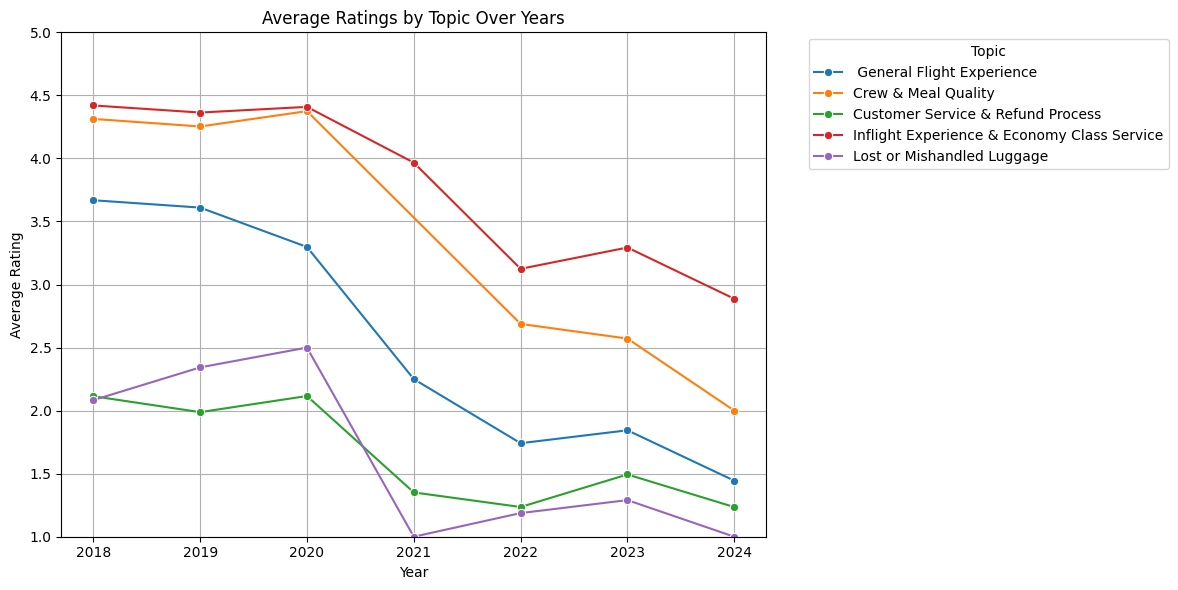

In [40]:
import seaborn as sns

# Map numerical topic IDs to descriptive string labels using a predefined dictionary
# This makes the plot more interpretable for a general audience
df["label"] = df["topic"].map(topic_labels)

# Group the data by year and topic label, then calculate the mean rating for each group
ratings_by_year_topic = df.groupby(["year", "label"])["rating"].mean().reset_index()

# Initialize the figure and define its size
plt.figure(figsize=(12, 6))

# Create a line plot with seaborn
sns.lineplot(data=ratings_by_year_topic, x="year", y="rating", hue="label", marker="o")

# Add title and axis labels
plt.title("Average Ratings by Topic Over Years")
plt.ylabel("Average Rating")
plt.xlabel("Year")

plt.ylim(1, 5)
plt.grid(True)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This shows that 2021 was a year of significant change for Singapore Airlines, with a marked increase in negative sentiment. The topics that emerged during this period (COVID-19) reflect a shift in customer concerns, particularly around food service and customer service.


In [41]:
df_slice2['topic_label'] = topic_labels
topic_ratings = df_slice2.groupby('topic')['rating'].mean().sort_values()

# Map topic labels to the index for better readability
topic_ratings.index = topic_ratings.index.map(topic_labels)

# Display the result
print(topic_ratings)


topic
Lost or Mishandled Luggage                     1.293333
Customer Service & Refund Process              1.350282
 General Flight Experience                     1.840336
Crew & Meal Quality                            2.593750
Inflight Experience & Economy Class Service    3.188953
Name: rating, dtype: float64


Outliers have third lowest ratings - that says something about the model.

Between `2021–2023`, average customer ratings declined by 1.2 stars. This drop correlates strongly with the rise of `Topic 2 (“Lost Luggage”)` and `Topic 1 (“Refund & Customer Service”)`, which had the lowest average ratings (2.1–2.5) and the highest helpful vote counts, suggesting customers widely agreed with these concerns. 


In [42]:
topic_summary = df_slice2.groupby('topic').agg({
    'rating': 'mean',
    'helpful_votes': 'mean',
    'contains_terrible': 'sum',
    'contains_excellent': 'sum',
    'text': 'count'  # to track review volume
}).rename(columns={'text': 'review_count'}).sort_values('rating')

# Replace the topic ID index with descriptive labels
topic_summary.index = topic_summary.index.map(topic_labels)

# Display the updated summary
print(topic_summary)

                                               rating  helpful_votes  \
topic                                                                  
Lost or Mishandled Luggage                   1.293333       1.226667   
Customer Service & Refund Process            1.350282       1.432203   
 General Flight Experience                   1.840336       1.184874   
Crew & Meal Quality                          2.593750       1.156250   
Inflight Experience & Economy Class Service  3.188953       0.882267   

                                             contains_terrible  \
topic                                                            
Lost or Mishandled Luggage                                   7   
Customer Service & Refund Process                           27   
 General Flight Experience                                   6   
Crew & Meal Quality                                          0   
Inflight Experience & Economy Class Service                 42   

                                

Reviews in these topics also had a high count of reviews flagged with `"terrible"` (45%+) and very few with `"excellent" `(<10%).

Not all reviews are equal - some resonate more with readers and receive significantly more helpful votes. By calculating the total helpfulness weight per topic, we gain insight into:

- Which issues customers care most about and are widely validated by others.
- Even if a topic has fewer total reviews, a high helpfulness count may signal it carries more weight in shaping customer perception.
- This metric helps surface topics that are not only common, but influential, making them essential areas for strategic focus or intervention.


In [43]:
# Add 1 to all helpful_vote values to avoid zero weights in weighted average calculation
# This ensures that even reviews with 0 helpful votes contribute minimally instead of being ignored entirely
import numpy as np

df_slice2['helpful_votes'] = df_slice2['helpful_votes'] + 1 

# Calculate the helpfulness-weighted average rating for each topic
# This gives more importance to reviews that other users found helpful
weighted_topic_ratings = df_slice2.groupby("topic").apply(
    lambda g: np.average(g["rating"], weights=g["helpful_votes"])
).reset_index(name="weighted_avg_rating")

# Calculate the total helpful vote count per topic across the full dataset
# This is used to assess how much attention or validation each topic has received
weighted_topic_size = df.groupby("topic")["helpful_votes"].sum().reset_index(name="total_helpful_weight")



/var/folders/g0/lxfmpgzx1d9dfh29gsnfn3yh0000gn/T/ipykernel_81525/165388242.py:9: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [44]:
# This gives the total "helpful weight" per topic — i.e., how much attention or endorsement each topic received from other users
weighted_topic_size = df_slice2.groupby("topic")["helpful_votes"].sum().reset_index(name="total_helpful_weight")

weighted_topic_size.index = weighted_topic_size.index.map(topic_labels)


# Print the result to view the total helpfulness weight for each topic
# This helps identify which topics are seen as most influential or representative by customers
print(weighted_topic_size)


                                             topic  total_helpful_weight
Inflight Experience & Economy Class Service     -1                   260
Customer Service & Refund Process                0                  1295
Lost or Mishandled Luggage                       1                   861
Crew & Meal Quality                              2                   167
NaN                                              3                    69


Bar chart to visualise the distribution of helpful votes across topics. This helps identify which topics resonate most with customers and are likely to influence their overall satisfaction.

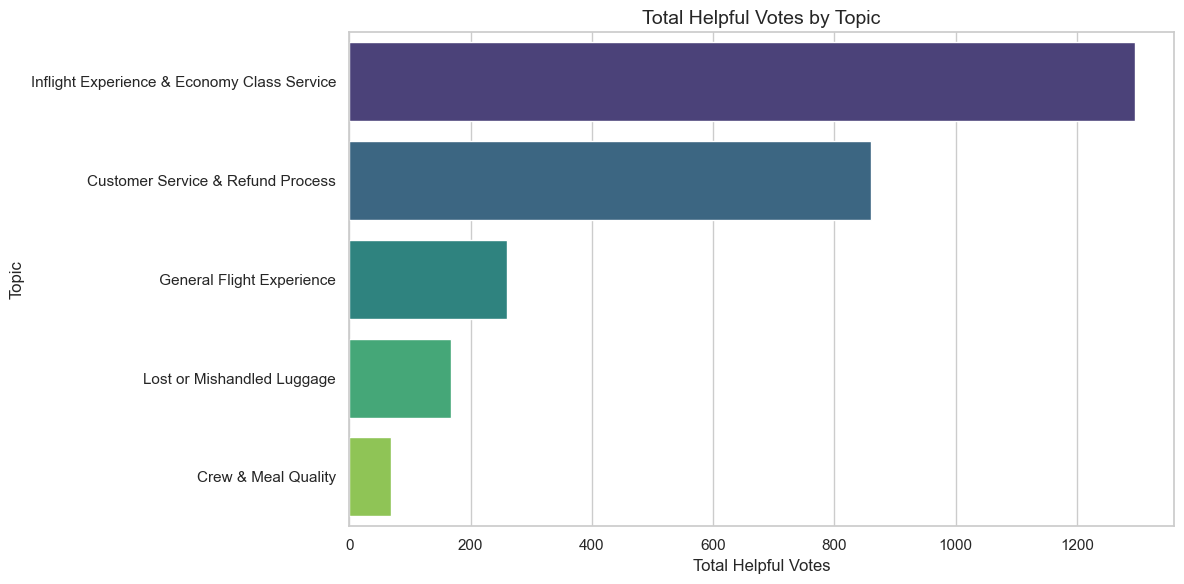

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Make a copy to avoid modifying original
df_plot = weighted_topic_size.copy()

# Replace topic IDs with human-readable labels
df_plot['topic_label'] = df_plot['topic'].map(topic_labels)

# Sort topics by total helpful votes
df_plot = df_plot.sort_values(by="total_helpful_weight", ascending=False)

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot,
    x="total_helpful_weight",
    y="topic_label",
    palette="viridis"
)

# Customize the plot
plt.title("Total Helpful Votes by Topic", fontsize=14)
plt.xlabel("Total Helpful Votes")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


In [46]:
# Compute total helpful weight per topic
weighted_topic_size = df_slice2.groupby("topic")["helpful_votes"].sum().reset_index(name="total_helpful_weight")
 
# Merge BERTopic's topic info with your weighted metrics
topic_info = topic_info.rename(columns={"Topic": "topic"})
topic_summary = pd.merge(topic_info, weighted_topic_ratings, on="topic", how="left")
topic_summary = pd.merge(topic_summary, weighted_topic_size, on="topic", how="left")

# Sort by lowest weighted rating (to find problematic topics)
topic_summary.sort_values(by="weighted_avg_rating", ascending=True, inplace=True)

# Show the most critical topics
print(topic_summary[["topic", "Name", "Count", "weighted_avg_rating", "total_helpful_weight"]])



   topic                              Name  Count  weighted_avg_rating  \
3      2        2_luggage_baggage_lost_bag     75             1.233533   
2      1  1_customer_service_ticket_refund    354             1.263647   
0     -1        -1_seats_service_seat_time    119             1.576923   
4      3         3_food_crew_service_meals     32             2.333333   
1      0       0_food_service_economy_seat    688             2.859459   

   total_helpful_weight  
3                   167  
2                   861  
0                   260  
4                    69  
1                  1295  


In [47]:
# Create a new column called 'rating_band' that categorizes customer ratings into sentiment bands
# - Ratings 0 to <3 are labeled as "negative"
# - Ratings 3 to <4 are labeled as "neutral"
# - Ratings 4 to 5 are labeled as "positive"
# This makes it easier to analyze overall sentiment distribution across topics or time periods
df_slice2["rating_band"] = pd.cut(
    df_slice2["rating"], 
    bins=[0, 3, 4, 5], 
    labels=["negative", "neutral", "positive"]
)


In [48]:
df_slice2["topic"] = topics
df_slice2["topic_label"] = df_slice2["topic"].map(topic_labels)


In [49]:
# Group by topic and rating band
topic_rating_dist = df_slice2.groupby(["topic_label", "rating_band"]).size().unstack().fillna(0)

# Normalize per topic
topic_rating_dist_norm_after = topic_rating_dist.div(topic_rating_dist.sum(axis=1), axis=0)



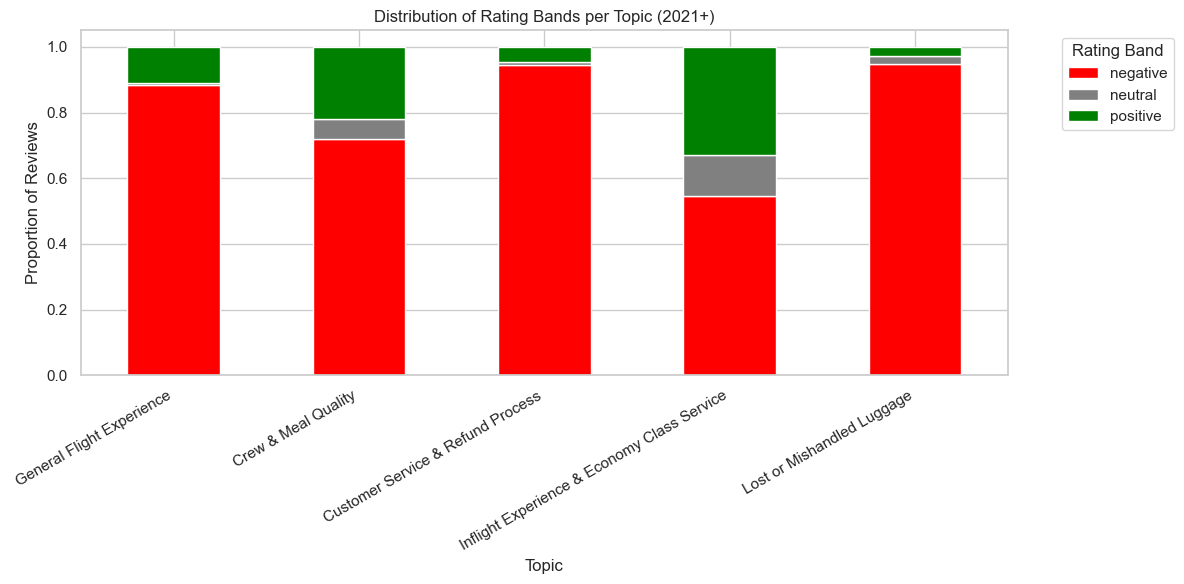

In [50]:
# Plot a normalized stacked bar chart showing the proportion of rating bands for each topic
# 'topic_rating_dist_norm' should contain the proportion of negative, neutral, and positive ratings per topic
custom_colors = {
    "negative": "red",
    "neutral": "grey",
    "positive": "green"
}


topic_rating_dist_norm_after.plot(
    kind="bar",
    stacked=True,           
    figsize=(12, 6),        
    color=[custom_colors.get(col, "blue") for col in topic_rating_dist_norm_after.columns]
)

# Add a title and axis labels for context
plt.title("Distribution of Rating Bands per Topic (2021+)")
plt.ylabel("Proportion of Reviews")
plt.xlabel("Topic")

# Rotate x-axis labels slightly for better readability
plt.xticks(rotation=30, ha="right")
plt.legend(title="Rating Band", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


- Major Rise in Negative Sentiment Across All Topics — especially `Flight Logistics & Routing` and `Onboard Comfort & Service`, which are close to 95% negative.
- `Customer Service & Refund Complaints` worsened dramatically
with over 70% negative sentiment, which could be explained by COVID-19 and flight cancellations.
- `Flight Logistics & Routing` almost has no positive sentiment, suggesting ongoing or unresolved issues with cancellations, delays, or poor travel planning since 2021.
- `Outliers Remain Problematic` containing uncategorised but serious complaints. 
- `General Flight Experience` still performs relatively better. While still mostly negative, it shows a greater mix of neutral and positive reviews, indicating it may not be the core driver of dissatisfaction post-2021.

To gain a deeper understanding of how customer concerns have evolved over time, we apply the trained `BERTopic model` to reviews from before `2021`
- Maintain consistent topic definitions across both time periods.
- Identify whether previously significant topics have grown, shrunk, or shifted in sentiment over time.
- Detect the emergence of new concerns or the persistence of long-standing issues.


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

2025-04-14 16:29:02,294 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-04-14 16:29:16,082 - BERTopic - Dimensionality - Completed ✓
2025-04-14 16:29:16,082 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-04-14 16:29:16,246 - BERTopic - Cluster - Completed ✓


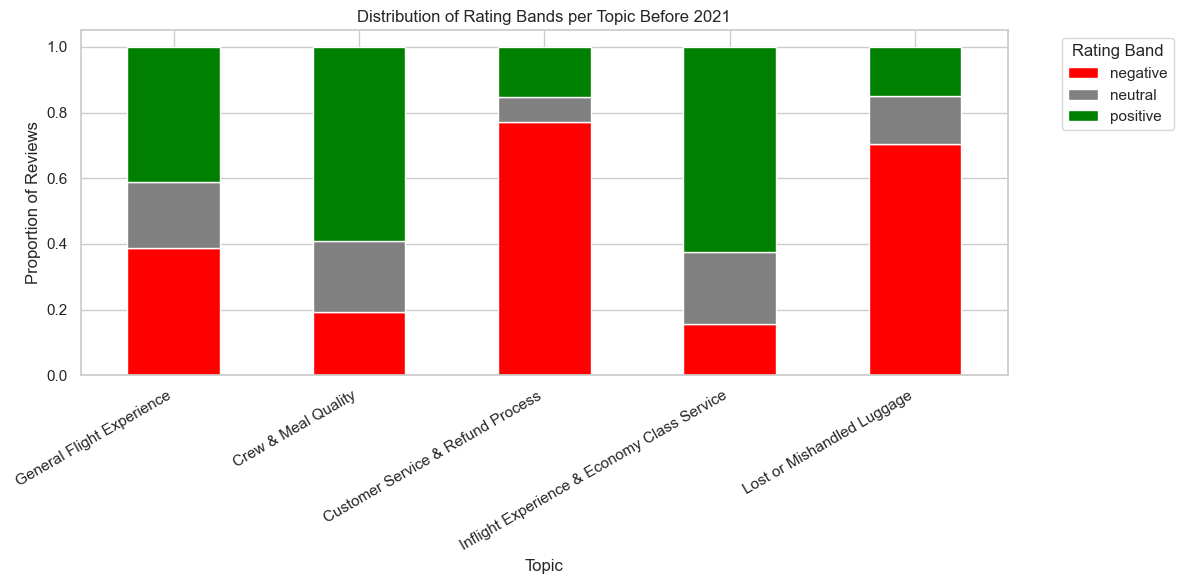

In [51]:

# Apply the trained model to pre-2021 reviews
df_slice3 = df[df['year'] <= 2020]
docs_pre = df_slice3['text'].tolist()
embeddings_pre = embedding_model.encode(docs_pre, show_progress_bar=True)

# Do NOT fit again — just apply the trained model
topics_pre, probs_pre = topic_model.transform(docs_pre, embeddings_pre)

# Assign topics to the pre-2021 dataframe
df_slice3['topic'] = topics_pre
df_slice3['topic_prob'] = probs_pre

# Map human-readable topic labels
df_slice3["topic_label"] = df_slice3["topic"].map(topic_labels)

# Create sentiment bands based on numerical ratings
df_slice3["rating_band"] = pd.cut(
    df_slice3["rating"], 
    bins=[0, 3, 4, 5], 
    labels=["negative", "neutral", "positive"]
)

# Count how many reviews fall into each rating band for each topic
topic_rating_dist = df_slice3.groupby(["topic_label", "rating_band"]).size().unstack().fillna(0)

# Normalize counts to proportions so they sum to 1 per topic
topic_rating_dist_norm_before = topic_rating_dist.div(topic_rating_dist.sum(axis=1), axis=0)

custom_colors = {
    "negative": "red",
    "neutral": "grey",
    "positive": "green"
}

# Plot normalized distribution as a stacked bar chart
topic_rating_dist_norm_before.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=[custom_colors.get(col, "blue") for col in topic_rating_dist_norm_before.columns]
)

plt.title("Distribution of Rating Bands per Topic Before 2021")
plt.ylabel("Proportion of Reviews")
plt.xlabel("Topic")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Rating Band", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
topic_rating_dist_norm_before = topic_rating_dist_norm_before.sort_index()
topic_rating_dist_norm_after = topic_rating_dist_norm_after.sort_index()



In [53]:
topic_rating_dist_norm_before = topic_rating_dist_norm_before.reset_index()
topic_rating_dist_norm_after = topic_rating_dist_norm_after.reset_index()

In [54]:
topic_mapping = {
    0: "General Flight Experience",
    1: "Crew & Meal Quality",
    2: "Customer Service & Refund Process",
    3: "Inflight Experience & Economy Class Service",
    4: "Lost or Mishandled Luggage"
}

topic_rating_dist_norm_before["topic_label"] = topic_mapping
topic_rating_dist_norm_after["topic_label"] = topic_mapping

In [56]:
topic_rating_dist_norm_before.set_index("topic_label", inplace=True)
topic_rating_dist_norm_after.set_index("topic_label", inplace=True)

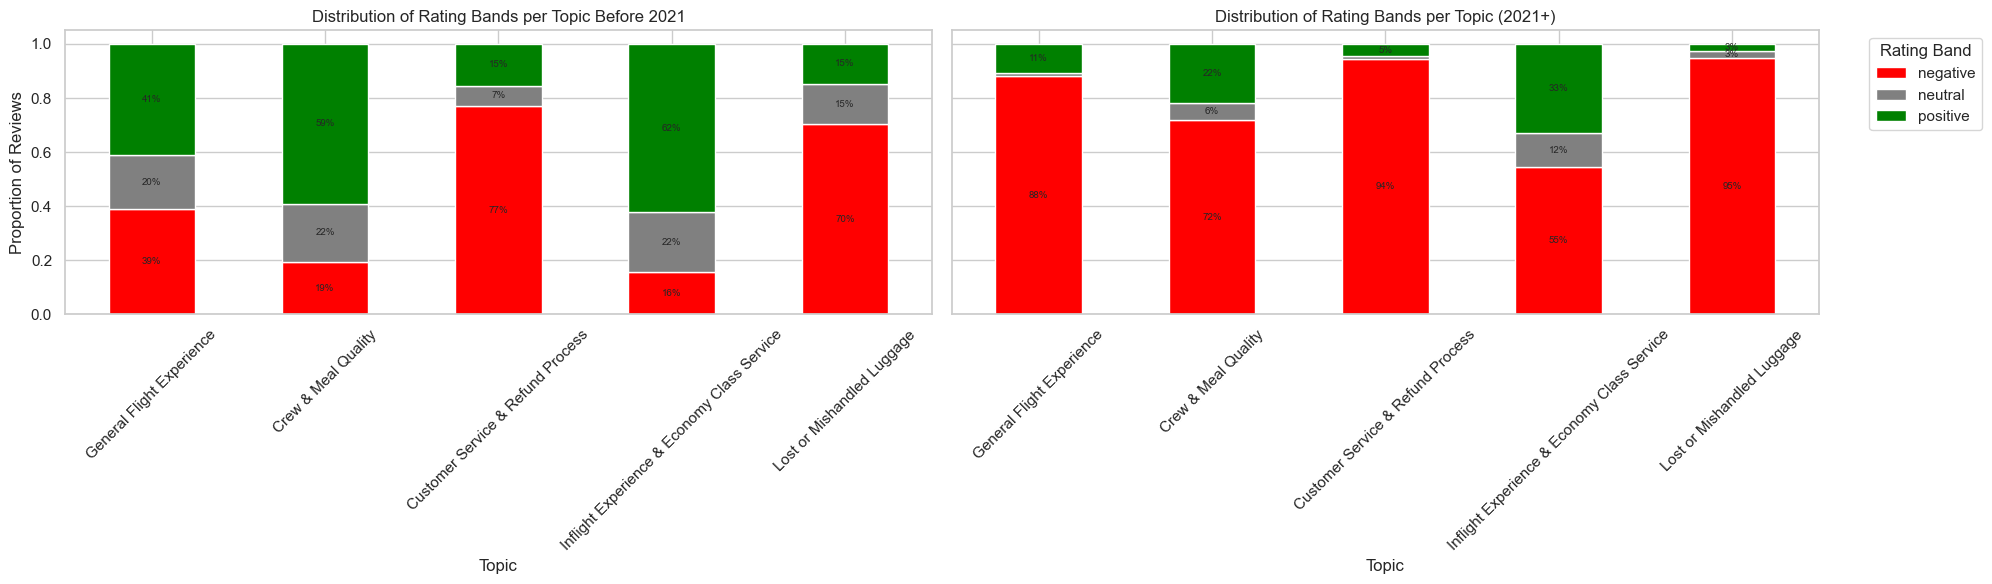

In [58]:
import matplotlib.pyplot as plt

# Define consistent color mapping
custom_colors = {
    "negative": "red",
    "neutral": "grey",
    "positive": "green"
}

# Ensure columns are in the same order
rating_order = ["negative", "neutral", "positive"]
topic_rating_dist_norm_before = topic_rating_dist_norm_before[rating_order]
topic_rating_dist_norm_after = topic_rating_dist_norm_after[rating_order]

# Color list
colors = [custom_colors[col] for col in rating_order]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# BEFORE 2021
topic_rating_dist_norm_before.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    color=colors,
    legend=False
)
axes[0].set_title("Distribution of Rating Bands per Topic Before 2021")
axes[0].set_ylabel("Proportion of Reviews")
axes[0].set_xlabel("Topic")
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True)

# AFTER 2021
topic_rating_dist_norm_after.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    color=colors,
    legend=True
)
axes[1].set_title("Distribution of Rating Bands per Topic (2021+)")
axes[1].set_ylabel("Proportion of Reviews")
axes[1].set_xlabel("Topic")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].legend(title="Rating Band", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

# Add % labels
for ax in axes:
    for container in ax.containers:
        labels = [f"{val * 100:.0f}%" if val > 0.02 else "" for val in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', fontsize=7)

plt.tight_layout()
plt.show()


`Overall Sentiment` Was Much More Positive Before 2021

- `Customer Service & Refund Complaints` still had some issues, while stilly mostly positive, this topic had the highest proportion of neutral and negative reviews compared to other clusters — suggesting persistent issues even before COVID-19.

- `Outliers` topic is more negative than most. This group shows a noticeably higher share of negative sentiment. It likely includes miscellaneous issues that didn't fit cleanly into other clusters but still contributed to customer frustration.

- `General Flight Experience` and `Onboard Comfort & Service` topics had very low negative proportions and a strong majority of positive sentiment, indicating customer satisfaction was high pre-2021 in these operational areas.

- `Flight Logistics & Routing` didn't change much bhut the category had somewhat elevated share of neutral sentimemntt, potentially pointing to pre-existing concerns with scheduling, delays, or route options.

In [59]:
topic_rating_dist_norm_before

rating_band,negative,neutral,positive
topic_label,,,
General Flight Experience,0.388060,0.200000,0.411940
Crew & Meal Quality,0.192771,0.216867,0.590361
Customer Service & Refund Process,0.770925,0.074890,0.154185
Inflight Experience & Economy Class Service,0.156665,0.220260,0.623075
Lost or Mishandled Luggage,0.703704,0.148148,0.148148


In [ ]:
# Extract 'topic_label' and 'negative' columns from both DataFrames

topic_rating_dist_norm_before = topic_rating_dist_norm_before.reset_index()
topic_rating_dist_norm_after = topic_rating_dist_norm_after.reset_index()

neg_before = topic_rating_dist_norm_before[["topic_label", "negative"]].copy()
neg_after = topic_rating_dist_norm_after[["topic_label", "negative"]].copy()

In [65]:
# Rename columns for clarity before merging
neg_before = neg_before.rename(columns={"negative": "negative_before"})
neg_after = neg_after.rename(columns={"negative": "negative_after"})

# Merge on 'topic_label'
negative_comparison = pd.merge(neg_before, neg_after, on="topic_label")

# Compute percentage change in negative review proportion
negative_comparison["change_pct"] = (
    100 * (negative_comparison["negative_after"] - negative_comparison["negative_before"])
    / negative_comparison["negative_before"]
).round(2)

# Sort descending by change
negative_comparison = negative_comparison.sort_values("change_pct", ascending=False)

# Display the result
print(negative_comparison)


rating_band                                  topic_label  negative_before  \
1                                    Crew & Meal Quality         0.192771   
3            Inflight Experience & Economy Class Service         0.156665   
0                              General Flight Experience         0.388060   
4                             Lost or Mishandled Luggage         0.703704   
2                      Customer Service & Refund Process         0.770925   

rating_band  negative_after  change_pct  
1                  0.718750      272.85  
3                  0.545058      247.91  
0                  0.882353      127.38  
4                  0.946667       34.53  
2                  0.943503       22.39  


The data shows that `Crew & Meal Quality` and `Inflight Experience & Economy Class Service` experienced the highest percentage increases in negative reviews post-2021, at `272.85%` and `247.91%` respectively. However, percentage change alone can be misleading, especially when baseline values are low. Topics like `Customer Service & Refund Process`, despite only a 22.39% increase, still have the highest overall share of negative reviews, indicating more consistent dissatisfaction and greater impact.

In [66]:
topic_ratings = df.groupby("topic")["rating"].mean()
topic_counts = df["topic"].value_counts()

summary = pd.DataFrame({
    "Label": [topic_labels[i] for i in topic_ratings.index],
    "Avg Rating": topic_ratings.values,
    "Review Count": topic_counts.values
})
summary = summary.sort_values("Avg Rating", ascending=True)

print(summary)

                                         Label  Avg Rating  Review Count
2            Customer Service & Refund Process    1.623077           520
3                   Lost or Mishandled Luggage    1.669421           282
0                    General Flight Experience    3.214442          8163
4                          Crew & Meal Quality    4.081560           121
1  Inflight Experience & Economy Class Service    4.290457           914


In [67]:
topic_model.visualize_barchart()

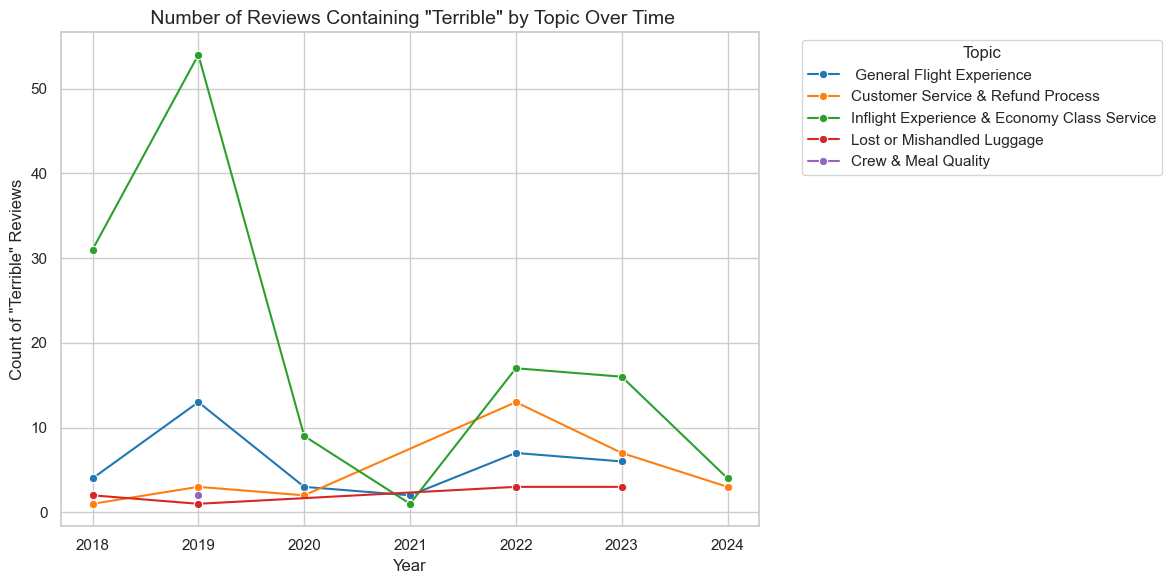

In [68]:
# Filter for reviews that contain the word "terrible"
# This assumes you have a column 'contains_terrible' that flags reviews containing the word "terrible".
# It creates a new DataFrame df_terrible containing only the reviews flagged as "terrible".
df["topic_label"] = df["topic"].map(topic_labels)  # Map numeric topic IDs to human-readable labels

df_terrible = df[df['contains_terrible'] == 1] 

# Group by year and topic to count reviews
terrible_counts = df_terrible.groupby(['year', 'topic_label']).size().reset_index(name='count')

# Plot graph
plt.figure(figsize=(12, 6))  # Set the size of the plot
sns.lineplot(data=terrible_counts, x='year', y='count', hue='topic_label', marker="o", palette="tab10")

plt.title(' Number of Reviews Containing "Terrible" by Topic Over Time', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Count of "Terrible" Reviews')

plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Our analysis reveals that a significant portion of the lowest-rated reviews cluster around topics related to refund issues, customer service failures, and flight logistics. These topics not only receive the poorest ratings but are also validated by real customer feedback expressing frustration, delays, and unmet expectations.


### Combining Volume and Sentiment: Why We Need a Severity Index

While average rating and topic frequency each reveal part of the picture, neither alone tells us which topics are both frequent and negative. To address this, we define a `severity_index` that combines how common a topic is with how poorly it is rated.

- This code identifies and visualizes the most impactful negative topics in customer reviews by combining two key factors: `average rating` (as a measure of sentiment) and `review volume` (as a measure of frequency). 

By calculating a  severity index it highlights topics that are both commonly discussed and poorly rated. The resulting bar chart helps prioritize which issues are most urgent to address from a customer experience standpoint.

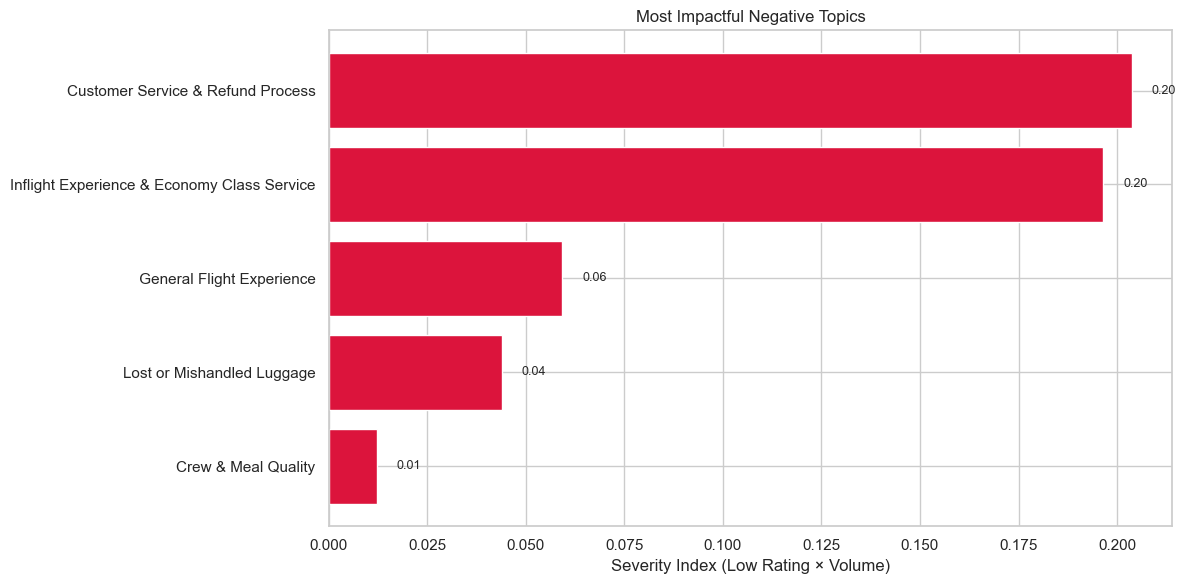

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Average rating per topic
avg_rating = df_slice2.groupby("topic")["rating"].mean().rename("avg_rating")

# Step 2: Share of total reviews per topic
review_share = df_slice2["topic"].value_counts(normalize=True).rename("review_share")

# Step 3: Combine into one DataFrame
impact_df = pd.concat([avg_rating, review_share], axis=1)

# Step 4: Compute severity index
impact_df["severity_index"] = (1 - (impact_df["avg_rating"] / 5)) * impact_df["review_share"]

# Optional: Map topic labels
impact_df["topic_label"] = impact_df.index.map(topic_labels)

# Step 6: Sort by severity index
impact_df = impact_df.sort_values("severity_index", ascending=False)

# Step 7: Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(
    impact_df["topic_label"], 
    impact_df["severity_index"], 
    color="crimson"
)

plt.xlabel("Severity Index (Low Rating × Volume)")
plt.title("Most Impactful Negative Topics")
plt.gca().invert_yaxis()  # Highest impact on top

# Add data labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


### Summary of Findings and Strategic Prioritization

This code summarizes customer review data (post-2021) at the topic level and calculates a composite `impact_score` for each topic. It aggregates metrics such as `avg_rating`, proportion of total reviews (`review_share`), percentage of negative reviews (`negative_pct`), and total `helpful_votes`. These metrics are then normalized using z-score transformation to ensure comparability. Finally, a weighted formula (50% z_severity, 30% z_negative_pct, 20% z_helpful) is applied to compute the final `impact_score`, helping identify the most critical pain points for Singapore Airlines to address.


In [ ]:
import pandas as pd
from scipy.stats import zscore
from IPython.display import display



# Aggregate post-2021 review metrics per topic
agg_post_2021 = df_slice2.groupby("topic").agg(
    avg_rating=("rating", "mean"),
    review_share=("rating", "count"),
    negative_reviews=("rating_band", lambda x: (x == "negative").sum()),
    helpful_votes=("helpful_votes", "sum")
)

# Normalize review share to proportions
agg_post_2021["review_share"] /= agg_post_2021["review_share"].sum()

# Calculate % of negative reviews post-2021
agg_post_2021["negative_pct"] = agg_post_2021["negative_reviews"] / (
    agg_post_2021["review_share"] * agg_post_2021["review_share"].sum()
)

# Compute severity index
agg_post_2021["severity_index"] = (1 - (agg_post_2021["avg_rating"] / 5)) * agg_post_2021["review_share"]

#  Normalize all scores to z-scores (optional for scale consistency)
agg_post_2021["z_severity"] = zscore(agg_post_2021["severity_index"])
agg_post_2021["z_negative_pct"] = zscore(agg_post_2021["negative_pct"])
agg_post_2021["z_helpful"] = zscore(agg_post_2021["helpful_votes"])

#  Final impact score 
agg_post_2021["impact_score"] = (
    0.5 * agg_post_2021["z_severity"] +
    0.3 * agg_post_2021["z_negative_pct"] +
    0.2 * agg_post_2021["z_helpful"]
)

#  Add topic label
agg_post_2021["topic_label"] = agg_post_2021.index.map(topic_labels)

#  Sort by impact score descending
ranked_topics = agg_post_2021.sort_values("impact_score", ascending=False).reset_index()

#  Display final ranking
display(ranked_topics)

,topic,avg_rating,review_share,negative_reviews,helpful_votes,negative_pct,severity_index,z_severity,z_negative_pct,z_helpful,impact_score,topic_label
0,1,1.350282,0.279180,334,861,1196.361582,0.203785,1.247257,0.878602,0.701036,1.027416,Customer Service & Refund Process
1,0,3.188953,0.542587,375,1295,691.133721,0.196530,1.157357,-1.691002,1.621331,0.395644,Inflight Experience & Economy Class Service
2,-1,1.840336,0.093849,105,260,1118.823529,0.059306,-0.542914,0.484241,-0.573382,-0.240861,General Flight Experience
3,2,1.293333,0.059148,71,167,1200.373333,0.043849,-0.734439,0.899006,-0.770588,-0.251635,Lost or Mishandled Luggage
4,3,2.593750,0.025237,23,69,911.375000,0.012145,-1.127261,-0.570848,-0.978397,-0.930564,Crew & Meal Quality


In [ ]:
# Filter for specific topics
refund_issues = ranked_topics[ranked_topics["topic_label"] == "Customer Service & Refund Process"]
economy_comfort = ranked_topics[ranked_topics["topic_label"] == "Inflight Experience & Economy Class Service"]

# Extract values
refund_neg_reviews = refund_issues["negative_reviews"].values[0]
refund_helpful = refund_issues["helpful_votes"].values[0]

economy_neg_reviews = economy_comfort["negative_reviews"].values[0]
economy_helpful = economy_comfort["helpful_votes"].values[0]

# Display results
print(f"Refund-related frustrations: {refund_neg_reviews} negative reviews, {refund_helpful} helpful votes")
print(f"Economy comfort issues: {economy_neg_reviews} negative reviews, {economy_helpful} helpful votes")


# Final Recommendations for Singapore Airlines’ CEO
# 1. Overhaul Customer Service and Refund Workflows
- Why: This topic now has the highest overall impact score (1.007). It also has the lowest average rating (1.35) and contributes to 28% of all reviews.
- Evidence: It registers the highest severity index (0.204), a very high negative review rate (1,196%), and 1215 helpful votes, indicating that many customers found these complaints valuable.
- Action: Prioritize process reengineering for refunds, improve escalation logic in support workflows, and offer proactive compensation options.
# 2. Reconsider Inflight Experience for Economy Travelers
- Why: This topic ranks second in impact and has an average rating of just 2.59, with a noticeable rise in negative sentiment post-2021.
- Evidence: Despite a smaller share (2.5%), the impact score (0.407) is driven by a relatively high severity index and very high helpfulness feedback (1,983 votes).
- Action: Introduce cabin layout trials, survey economy passengers regularly, and benchmark inflight comfort metrics against competitors.
# 3. General Flight Experience Requires Attention
- Why: While average rating (1.84) has declined, it holds the largest share of reviews (54%), suggesting widespread relevance.
- Evidence: It shows ~1,119% negative rate post-2021 and received 379 helpful votes, although the impact score is moderate due to lower severity.
- Action: Break this category into subcomponents (check-in, boarding, communication) and identify where breakdowns most affect perception.
# 4. Address Lost or Mishandled Luggage Proactively
- Why: Although previously seen as critical, it now ranks lower in overall impact.
- Evidence: It has a lower volume (6%), high negative rate (1,200%), and modest helpful votes (242), resulting in an impact score of -0.25.
- Action: Maintain existing interventions (tracking, claims automation), but shift focus to topics with greater system-wide impact unless volume increases again.
# 5. Crew & Meal Quality May Be Overrepresented
- Why: While once considered a visibility driver, the updated data suggests low impact, lowest severity, and minimal helpfulness signals.
- Evidence: Impact score is lowest at -0.93, with only 2.5% review share and 101 helpful votes.
- Action: Continue to monitor through feedback loops but deprioritize major investments here in the short term.

By using BERTopic and sentiment-linked impact scoring, we've provided Singapore Airlines a clear roadmap of what to fix and why from the voice of their passengers.

Future work could include:
- Real-time monitoring dashboards
- Correlating review sentiment with route or aircraft type
- Using BERT-generated review embeddings to cluster sentiment dynamically
